### Задание 1

Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

### Задание 2.

Обучите модель 2-ого уровня, при этом:
- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
- Вырос ли precision@5 при использовании двухуровневой модели?

_____

Качаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import re

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als
from implicit.nearest_neighbours import ItemItemRecommender

# Модель второго уровня
import lightgbm as lgb

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, ap_k
from src.utils import prefilter_items, get_result_table
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

Необходимые файлы:

In [2]:
data = pd.read_csv('../../data/retail_train.csv')
item_features = pd.read_csv('../../data/product.csv')
user_features = pd.read_csv('../../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


Оставляем себе 5000 строк:

In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print(f'количество элементов уменьшего с {n_items_before} по {n_items_after}')

количество элементов уменьшего с 83685 по 5001


Вот result, чтоб было, c чем сравнивать:

In [4]:
result_lvl_1 = get_result_table(data_val_lvl_1)
result_lvl_2 = get_result_table(data_val_lvl_2)
display(result_lvl_1.head(2), result_lvl_2.head(2))

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


Соберём рекомендации с разными k по алгоритму ItemItemRecommender (он побыстрее) в один список:

In [5]:
%%time
result_all_recomendations_dict, result_mean_recall_list = [], []

for i in [10, 50, 100, 200, 500]:
    recom = MainRecommender(data_train_lvl_1, item_item_recommend=True, N=i)
    recom.generate_recommendations()
    recommendations_dict = recom.recommendations
    result_all_recomendations_dict.append(recommendations_dict)
    
    recalls = []
    for user_id, recommended_list in recommendations_dict.items():
        bought_list = result_lvl_1[result_lvl_1['user_id'] == user_id]['actual']
        if len(bought_list) > 0:
            bought_list = bought_list.iloc[0]
            recall = recall_at_k(recommended_list, bought_list, k=i)
            recalls.append(recall)

    mean_recall = np.mean(recalls)
    result_mean_recall_list.append((i, mean_recall))

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 44min 39s


Вот что получилось:

In [6]:
result_mean_recall_list

[(10, 0.03125458492985768),
 (50, 0.07351979446351604),
 (100, 0.09067277610756397),
 (200, 0.11350370889454986),
 (500, 0.15153366267228185)]

Посмотрим на графике:

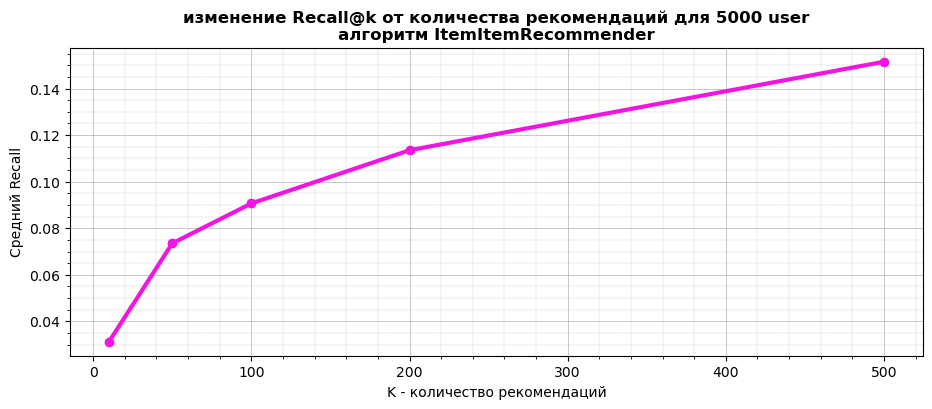

In [7]:
ks, recalls = zip(*result_mean_recall_list)

plt.figure(figsize=(11, 4))
plt.plot(ks, recalls, '-o', c='#F214E1', lw=3)
plt.title('изменение Recall@k от количества рекомендаций для 5000 user\nалгоритм ItemItemRecommender',
          fontweight='bold')
plt.xlabel('K - количество рекомендаций')
plt.ylabel('Средний Recall')
plt.minorticks_on()
plt.grid(which='major', linewidth=.5)
plt.grid(which='minor', linewidth=.25, linestyle='--');

Вот так мы видим, что от увеличения количества рекомендация значение Recall растёт, при этом явно видно то, что рост Recall от 100 до 500-т рекомендаций уже не такой быстрый, а значит нам будет из чего выбрать и при при K рекомендаций = 100 для того, чтобы из них отранжировать лучшие $\Rightarrow$ остановимся на них.

_____

Данные обсчитывали долго, было бы жалко их потерять - сохраним в файл:

In [8]:
with open('result_all_recomendations_dict.pkl', 'wb') as f:
    pickle.dump(result_all_recomendations_dict, f)

In [9]:
with open('result_all_recomendations_dict.pkl', 'rb') as f:
    result_all_recomendations_dict = pickle.load(f)

Добавим столбец с рекомендациями к датафрейму result_lvl_1 и посмотрим на него:

In [10]:
result_lvl_1['Item_item_recommendations'] = result_lvl_1['user_id'].map(result_all_recomendations_dict[2])
result_lvl_1.head(3)

,user_id,actual,Item_item_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[909714, 974204, 1138596, 898121, 920025, 8356..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[850601, 7152319, 9553382, 986912, 1056933, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[995965, 1101010, 1065538, 923169, 866211, 926..."


Теперь для второго этапа формируем тренировочный и тестовый датасеты и посмотрим на них:

In [11]:
def create_targets(data_lvl_2, train_data_lvl_1, item_feats, user_feats):
    """функция формирует датафрейм для второго алгоритма"""
    
    users_lvl_2 = pd.DataFrame(data_lvl_2['user_id'].unique())
    users_lvl_2.columns = ['user_id']
    train_users = train_data_lvl_1['user_id'].unique()
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    
    recs = result_lvl_1[result_lvl_1['user_id'].isin(users_lvl_2['user_id'])][['user_id', 'Item_item_recommendations']]
    users_lvl_2 = users_lvl_2.merge(recs, on='user_id', how='left')
    users_lvl_2.dropna(subset=['Item_item_recommendations'], inplace=True) # на случай, если попались пропуски
    users_lvl_2.rename(columns={'Item_item_recommendations': 'candidates'}, inplace=True)
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1
    
    targets = data_lvl_2[['user_id', 'item_id']].copy()
    targets['target'] = 1
    targets = users_lvl_2.merge(targets, on=['user_id', 'item_id'], how='left')
    targets['target'].fillna(0, inplace= True)
    targets.drop('flag', axis=1, inplace=True)
    targets = targets.merge(item_feats, on='item_id', how='left')
    targets = targets.merge(user_feats, on='user_id', how='left')
    
    return targets

In [12]:
targets_lvl_2 = create_targets(data_train_lvl_2, data_train_lvl_1, item_features, user_features)
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,916990,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK MLT-PK BTL CARB (EXCP,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,862535,0.0,794,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,16.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [13]:
test_targets_lvl_2 = create_targets(data_val_lvl_2, data_train_lvl_1, item_features, user_features)
test_targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,338,899624,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,1107760,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Генерируем новые признаки:

In [14]:
# Новые признаки по пользователю:
# Средняя сумма трат пользователя в каждой категории товаров (department);
user_mean_spending = targets_lvl_2.groupby(['user_id', 'department'])['target'].mean().reset_index()
user_mean_spending.rename(columns={'target': 'user_mean_spending'}, inplace=True)
targets_lvl_2 = pd.merge(targets_lvl_2, user_mean_spending, on=['user_id', 'department'], how='left')
test_targets_lvl_2 = pd.merge(test_targets_lvl_2, user_mean_spending, on=['user_id', 'department'], how='left')

# Количество уникальных брендов, которые купил пользователь.
user_unique_brands = targets_lvl_2.groupby('user_id')['brand'].nunique().reset_index()
user_unique_brands.rename(columns={'brand': 'user_unique_brands'}, inplace=True)
targets_lvl_2 = pd.merge(targets_lvl_2, user_unique_brands, on='user_id', how='left')
test_targets_lvl_2 = pd.merge(test_targets_lvl_2, user_unique_brands, on='user_id', how='left')

# Новые признаки по товару:
# Цена за единицу продукта;
price_per_unit = data.groupby('item_id')['sales_value'].mean() / data.groupby('item_id')['quantity'].mean()
price_per_unit = price_per_unit.reset_index()
price_per_unit.rename(columns={0: 'price_per_unit'}, inplace=True)
targets_lvl_2 = pd.merge(targets_lvl_2, price_per_unit, on='item_id', how='left')
test_targets_lvl_2 = pd.merge(test_targets_lvl_2, price_per_unit, on='item_id', how='left')

# Доля продаж данного товара от общего количества продаж в его категории товаров.
item_sales_share = targets_lvl_2.groupby(['department', 'item_id'])['target'].sum() / targets_lvl_2.groupby('department')['target'].sum()
item_sales_share = item_sales_share.reset_index()
item_sales_share.rename(columns={'target': 'item_sales_share'}, inplace=True)
targets_lvl_2 = pd.merge(targets_lvl_2, item_sales_share, on=['department', 'item_id'], how='left')
test_targets_lvl_2 = pd.merge(test_targets_lvl_2, item_sales_share, on=['department', 'item_id'], how='left')


# Новые признаки по паре user-item:
# Количество покупок данного товара пользователем;
user_item_purchases = targets_lvl_2.groupby(['user_id', 'item_id'])['target'].count().reset_index()
user_item_purchases.rename(columns={'target': 'user_item_purchases'}, inplace=True)
targets_lvl_2 = pd.merge(targets_lvl_2, user_item_purchases, on=['user_id', 'item_id'], how='left')
test_targets_lvl_2 = pd.merge(test_targets_lvl_2, user_item_purchases, on=['user_id', 'item_id'], how='left')

Сформируем предсказание и посчитаем для него метрику:

In [15]:
target = 'target'
num_columns = ['manufacturer', 'user_mean_spending', 'user_unique_brands',
              'price_per_unit', 'item_sales_share', 'user_item_purchases']

cat_columns = ['department', 'brand', 'commodity_desc',
            'sub_commodity_desc', 'sub_commodity_desc', 'age_desc',
            'marital_status_code', 'income_desc', 'homeowner_desc',
            'hh_comp_desc', 'household_size_desc', 'kid_category_desc']

def replace_col_names(df):
    pattern = "[^A-Za-z0-9_]+"
    new_cols = []
    for col in df.columns:
        new_col = re.sub(pattern, "_", col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

encoded_cat_columns_train = pd.get_dummies(targets_lvl_2[cat_columns], prefix=cat_columns, drop_first=True)
train_data = pd.concat([targets_lvl_2[num_columns], encoded_cat_columns_train], axis=1)

encoded_cat_columns_test = pd.get_dummies(test_targets_lvl_2[cat_columns], prefix=cat_columns, drop_first=True)
test_data = pd.concat([test_targets_lvl_2[num_columns], encoded_cat_columns_test], axis=1)

train_data = train_data.loc[:, ~train_data.columns.duplicated(keep='last')]
test_data = test_data.loc[:, ~test_data.columns.duplicated(keep='last')]

train_data = replace_col_names(train_data)
test_data = replace_col_names(test_data)

# Разделение выборки на обучающую и тестовую
train_labels = targets_lvl_2[target]
test_labels = test_targets_lvl_2[target]

params = {
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# Обучение модели
model = lgb.LGBMClassifier(**params)
model.fit(train_data, train_labels)

# Получение прогнозов и ранжирование рекомендаций для каждого пользователя
preds = model.predict_proba(test_data)[:, 1]  # вероятности класса "1"
test_targets_lvl_2['score'] = preds
test_targets_lvl_2['rank'] = test_targets_lvl_2.groupby('user_id')['score'].rank(ascending=False)

# Выбор топ-10 рекомендаций для каждого пользователя
top_k = 10
recommendations = (
    test_targets_lvl_2.query(f'rank <= {top_k}')
    .groupby('user_id')['item_id']
    .apply(list)
    .reset_index()
)

# Подсчет метрики AP@K
true_values = test_targets_lvl_2.query('target == 1').groupby('user_id')['item_id'].apply(list)
recommended_values = recommendations.set_index('user_id')['item_id']

ap_k_scores, recall_at_k_scores = [], []
for user_id in true_values.index:
    recommended_list = recommended_values.get(user_id, [])
    if len(recommended_list) >= top_k:
        ap_k_score = ap_k(recommended_list, true_values[user_id], k=top_k)
        recall_at_k_score = recall_at_k(recommended_list, true_values[user_id], k=top_k)
        ap_k_scores.append(ap_k_score)
        recall_at_k_scores.append(recall_at_k_score)

mean_ap_k_score = np.mean(ap_k_scores)
mean_recall_at_k_score = np.mean(recall_at_k_scores)
print(f'среднее AP@{top_k} = {mean_ap_k_score:.4f}\nсредний Recall@{top_k} = {mean_recall_at_k_score:.4f}')

среднее AP@10 = 0.0840
средний Recall@10 = 0.3752


_____

### Вывод

Recall@k вырос более чем в 2 раза от лучших значений одноуровневого алгоритма при аж 500 реокомендациях, а сейчас мы на первом уровне оставили по 100 рекомендаций, а на втором 10 и получили такие хорошие попадания, а значит алгоритм работает и работает исправно.

_____